# **Lending Club Loan Default Prediction**

LendingClub is an American peer-to-peer lending company. It enables borrowers to create unsecured personal loans while investors can choose the loan to invest based on the information provided.

Borrowers pay the interest for the loan to settle their financial hardship. Investors make money from the interest. In the meanwhile, the platform charges startup fees from borrowers and service fees from investors.

One main concern of investors is whether borrowers would default on loans or not. If the default does happen, investors would lose their investment. In this project, I used the Light GBM and MLP to predict the borrowers' loan status and achieved an accuracy of 85%.


## *Table of Contents*

I. [Exploratory Data Analysis](#I.-Exploratory-Data-Analysis)<br>
II. [Feature Engineering](#II.-Feature-Engineering)<br>
III. [Model Fitting](#III.-Model-Fitting)<br>
IV. [Model Evaluation](#IV.-Model-Evaluation)<br>
V. [Conclusion](#V.-Conclusion)<br>


## Import packages and load the data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


pd.set_option('display.max_columns', 60)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)


def ignore_warn(*args, **kwargs):
    pass


# ignore annoying warning (from sklearn and seaborn)
warnings.warn = ignore_warn

In [2]:
RawLoan = pd.read_csv('Loan.csv')
RawLoan.shape

(42538, 56)

In [3]:
# Show the first five rows
RawLoan.head()

id  loan_amnt  funded_amnt  funded_amnt_inv        term int_rate  \
0  NaN   5000.000     5000.000         4975.000   36 months   10.65%   
1  NaN   2500.000     2500.000         2500.000   60 months   15.27%   
2  NaN   2400.000     2400.000         2400.000   36 months   15.96%   
3  NaN  10000.000    10000.000        10000.000   36 months   13.49%   
4  NaN   3000.000     3000.000         3000.000   60 months   12.69%   

   installment grade sub_grade                 emp_title emp_length  \
0      162.870     B        B2                       NaN  10+ years   
1       59.830     C        C4                     Ryder   < 1 year   
2       84.330     C        C5                       NaN  10+ years   
3      339.310     C        C1       AIR RESOURCES BOARD  10+ years   
4       67.790     B        B5  University Medical Group     1 year   

  home_ownership  annual_inc verification_status   issue_d  loan_status  \
0           RENT   24000.000            Verified  Dec-2011   Fully Paid   
1           RENT   30000.000     Source Verified  Dec-2011  Charged Off   
2           RENT   12252.000        Not Verified  Dec-2011   Fully Paid   
3           RENT   49200.000     Source Verified  Dec-2011   Fully Paid   
4           RENT   80000.000     Source Verified  Dec-2011   Fully Paid   

  pymnt_plan                                               desc  \
0          n    Borrower added on 12/22/11 > I need to upgra...   
1          n    Borrower added on 12/22/11 > I plan to use t...   
2          n                                                NaN   
3          n    Borrower added on 12/21/11 > to pay for prop...   
4          n    Borrower added on 12/21/11 > I plan on combi...   

          purpose                 title zip_code addr_state    dti  \
0     credit_card              Computer    860xx         AZ 27.650   
1             car                  bike    309xx         GA  1.000   
2  small_business  real estate business    606xx         IL  8.720   
3           other              personel    917xx         CA 20.000   
4           other              Personal    972xx         OR 17.940   

   delinq_2yrs earliest_cr_line  inq_last_6mths  mths_since_last_delinq  \
0        0.000         Jan-1985           1.000                     nan   
1        0.000         Apr-1999           5.000                     nan   
2        0.000         Nov-2001           2.000                     nan   
3        0.000         Feb-1996           1.000                  35.000   
4        0.000         Jan-1996           0.000                  38.000   

   mths_since_last_record  open_acc  pub_rec  revol_bal revol_util  total_acc  \
0                     nan     3.000    0.000  13648.000      83.7%      9.000   
1                     nan     3.000    0.000   1687.000       9.4%      4.000   
2                     nan     2.000    0.000   2956.000      98.5%     10.000   
3                     nan    10.000    0.000   5598.000        21%     37.000   
4                     nan    15.000    0.000  27783.000      53.9%     38.000   

  initial_list_status  out_prncp  out_prncp_inv  total_pymnt  total_pymnt_inv  \
0                   f      0.000          0.000     5863.155         5833.840   
1                   f      0.000          0.000     1014.530         1014.530   
2                   f      0.000          0.000     3005.667         3005.670   
3                   f      0.000          0.000    12231.890        12231.890   
4                   f      0.000          0.000     4066.908         4066.910   

   total_rec_prncp  total_rec_int  total_rec_late_fee  recoveries  \
0         5000.000        863.160               0.000       0.000   
1          456.460        435.170               0.000     122.900   
2         2400.000        605.670               0.000       0.000   
3        10000.000       2214.920              16.970       0.000   
4         3000.000       1066.910               0.000       0.000   

   collection_recovery_fee la

In [4]:
# drop id column
Loan = RawLoan.drop(columns=['id'])
# drop rows with NA's for all columns
Loan = Loan.dropna(axis=0, how='all')

In [5]:
# Turn the interest rate into a numerical feature
Loan['int_rate'] = Loan['int_rate'].apply(lambda x: float(x[:-1])/100)

In [6]:
# check for missing value


def check_missing_value(df):
    '''Check for missing values in df 
        Print the column names and 
        the number of missing values in each column
    '''
    missing_value_column_name = []
    for i, j in zip(df.columns, df.isnull().sum(axis=0)):
        if j > 0:
            print(i, j, df[i].dtype)
            missing_value_column_name.append(i)
    print("The number of columns with missing values:",
          len(missing_value_column_name))

# ***I. Exploratory Data Analysis***



From the bar chart below, we notice that quite a high proportion of the loan applicants is on the purpose of paying their other sources of obligations.

Text(0.5, 1.0, 'Purpose of Loan')

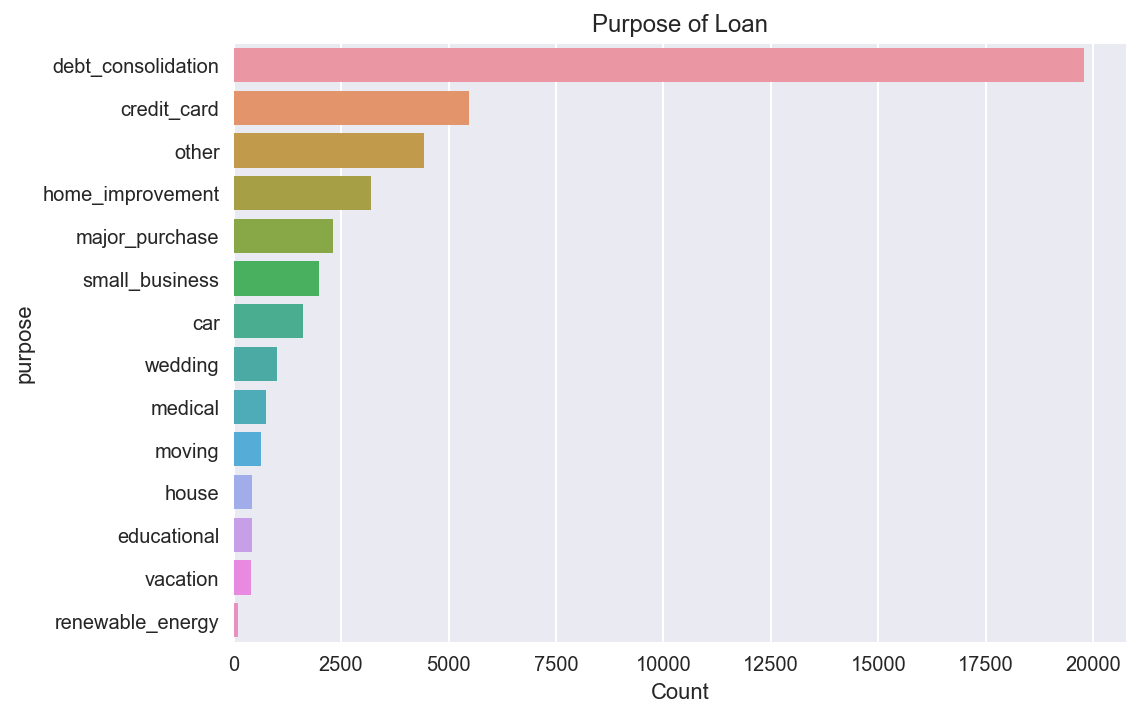

In [7]:
# Loan Purpose
plt.style.use('seaborn')
sns.countplot(y="purpose", data=Loan,
              order=Loan["purpose"].value_counts().index)
plt.xlabel('Count')
plt.title('Purpose of Loan')

The interest rate shows a  strong correlation with the credit grade. The higher the credit grade, the lower the interest rate.

Text(0, 0.5, 'Interest Rate')

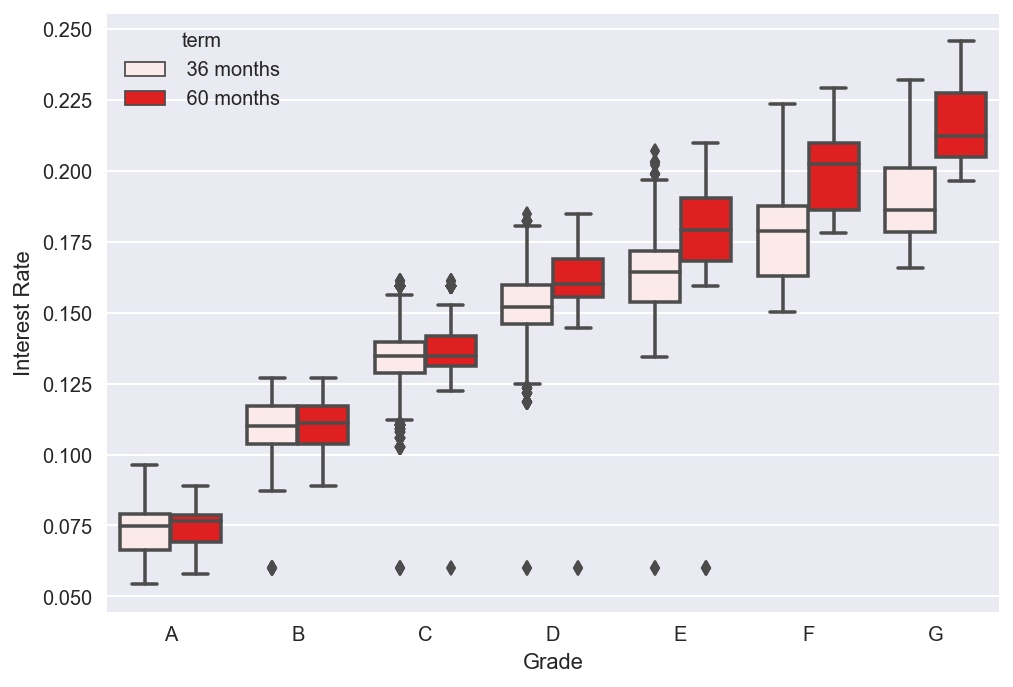

In [8]:
sns.boxplot(x='grade', y='int_rate', data=Loan,
            order=['A', 'B', 'C', 'D', 'E', 'F', 'G'], hue='term', color='r')
plt.xlabel('Grade')
plt.ylabel('Interest Rate')

In [9]:
Loan.groupby('term').mean()['int_rate']

term
 36 months   0.112
 60 months   0.149
Name: int_rate, dtype: float64

On average, the interest rate of a 60-month term loan is 3.7 % higher than that of a 36-month term loan. We can also see that the interest rates differ among different loan purposes. The maximum loan limit is up to $35,000.

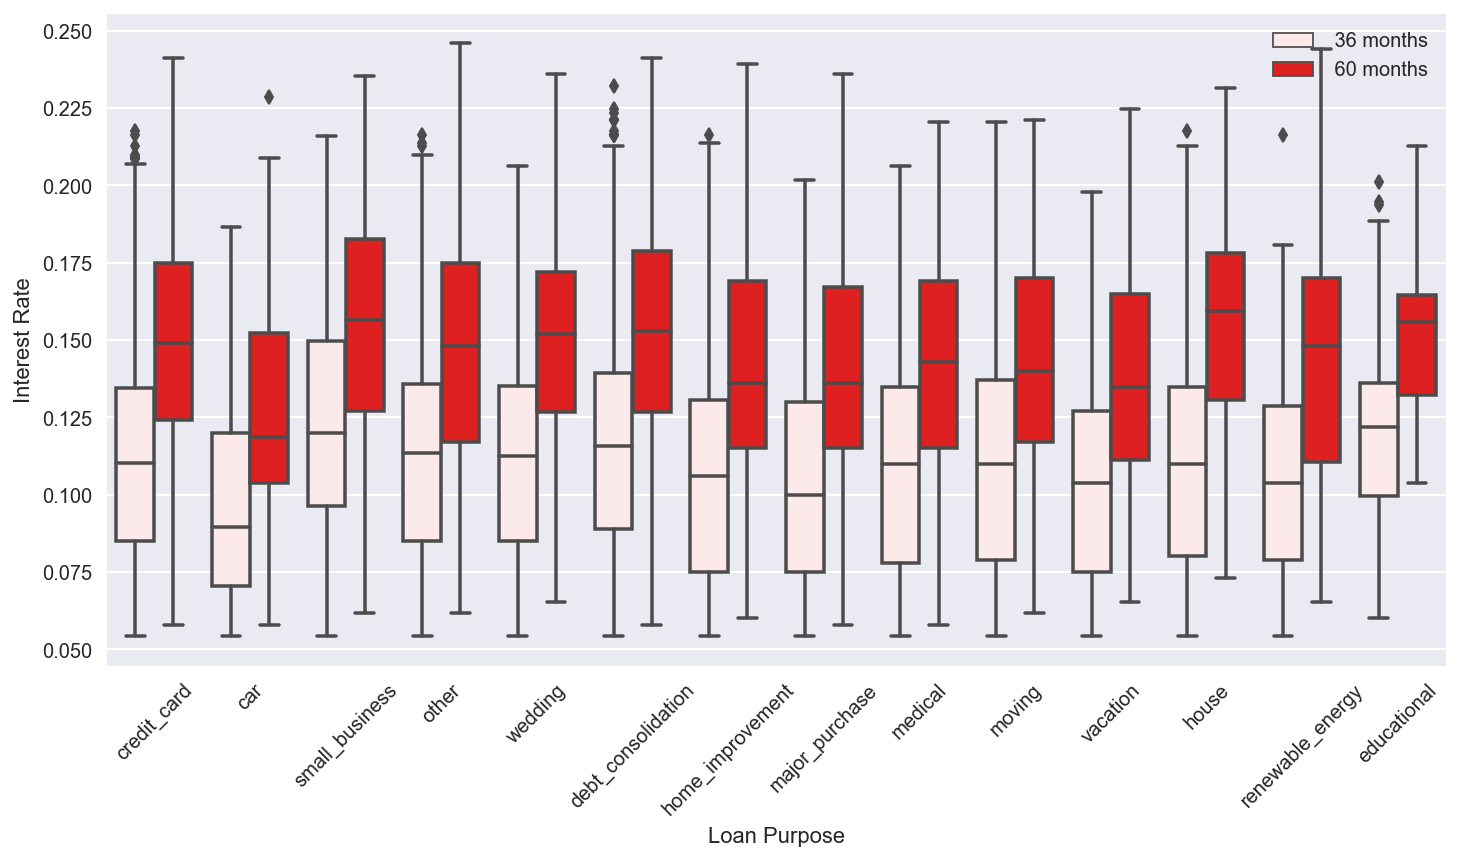

In [10]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='purpose', y='int_rate', data=Loan, hue='term', color='r')
plt.ylabel('Interest Rate')
plt.xlabel('Loan Purpose')
plt.xticks(rotation=45)
plt.legend(loc='upper right')

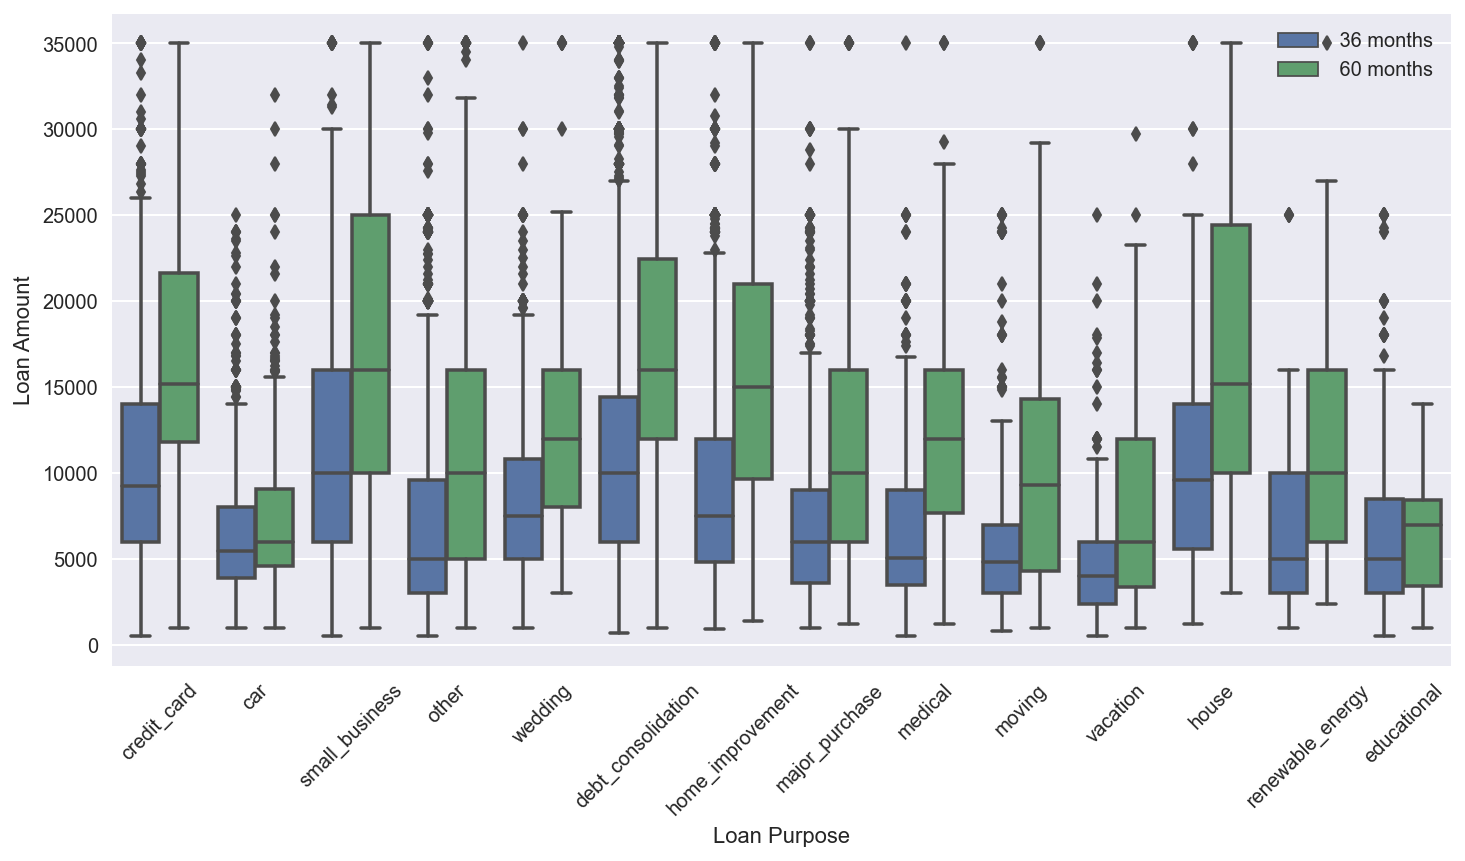

In [11]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='purpose', y='loan_amnt', data=Loan, hue='term')
plt.ylabel('Loan Amount')
plt.xlabel('Loan Purpose')
plt.xticks(rotation = 45)
plt.legend(loc='upper right');

The geographical distribution of lenders is consistent with America's demographic profile.

In [12]:
import plotly.graph_objects as go

df_location = Loan.groupby(["addr_state"]).sum().reset_index()
df_location = df_location.filter(["addr_state", "loan_amnt"], axis=1)

fig = go.Figure(data=go.Choropleth(
    locations=df_location['addr_state'],  # Spatial coordinates
    z=df_location['loan_amnt'].astype(float),  # Data to be color-coded
    locationmode='USA-states',  # set of locations match entries in `locations`
    colorscale='Reds',
    colorbar_title="Millions USD",
))

fig.update_layout(
    title_text='Total amount issued by State',
    geo_scope='usa',  # limited map scope to USA
)

fig.show()

The debt to income ratio is calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income. Most of these borrowers have a rough 15% debt to income ratio. We can see that maximum is no greater than 30%. 

Text(0.5, 1.0, 'Histogram of Debt to Income Ratio')

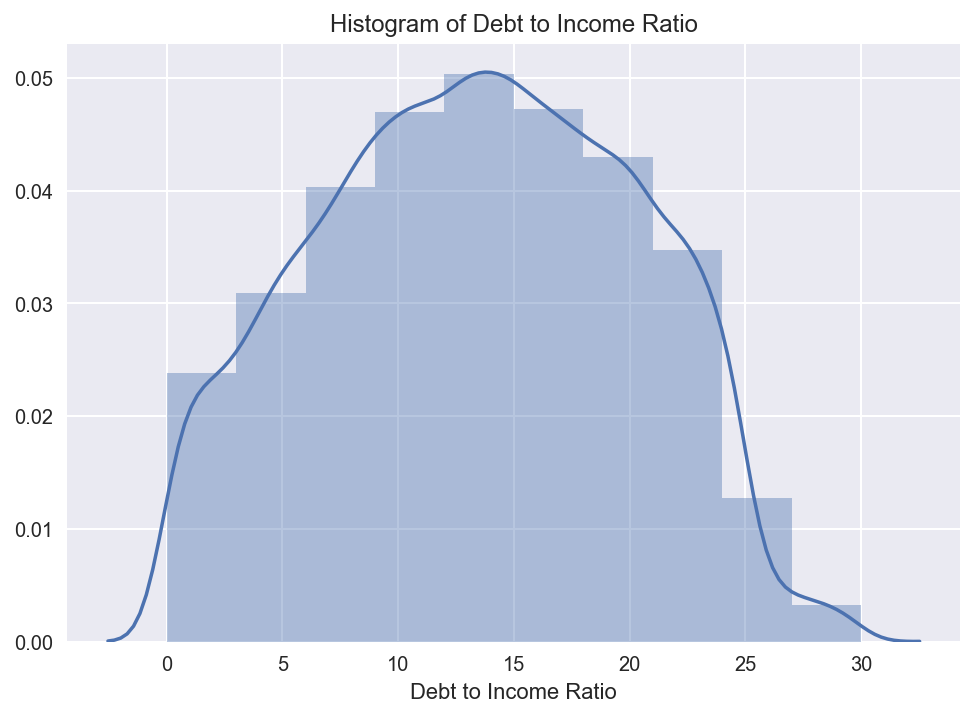

In [13]:
sns.distplot(Loan['dti'], bins=10)
plt.xlabel("Debt to Income Ratio")
plt.title("Histogram of Debt to Income Ratio")

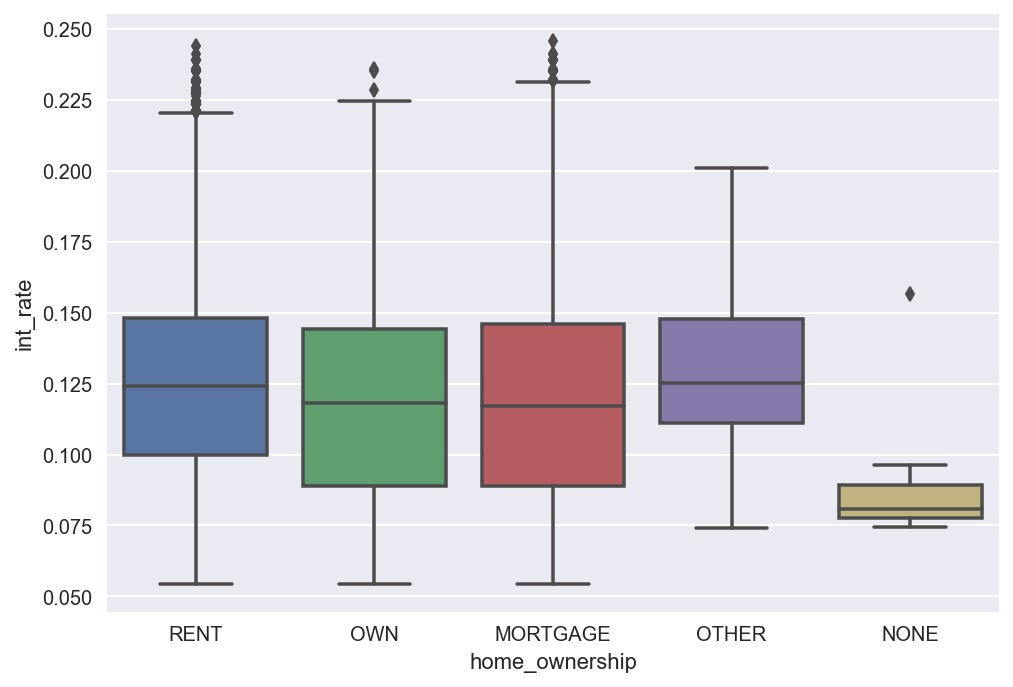

In [14]:
sns.boxplot(x='home_ownership', y='int_rate', data=Loan)

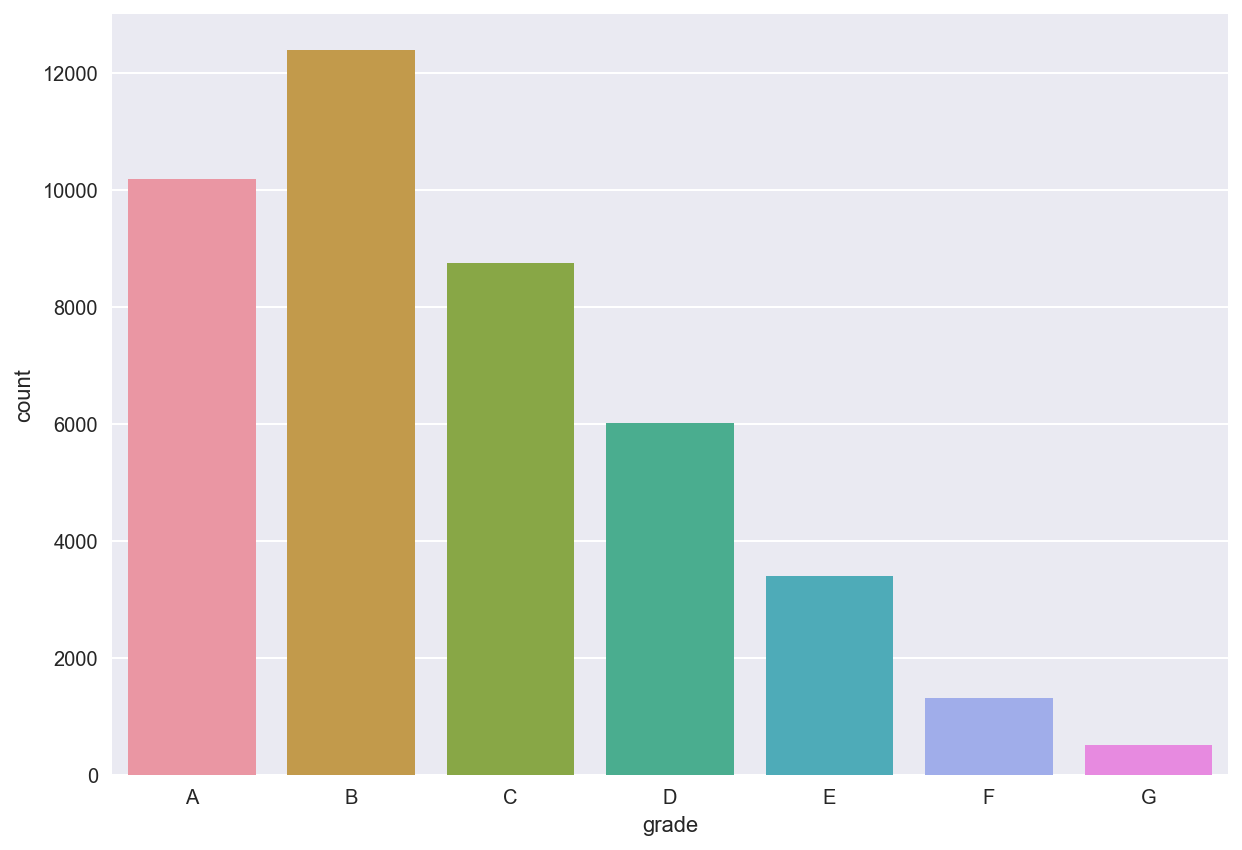

In [15]:
plt.figure(figsize=(10, 7))
sns.countplot(x="grade", data=Loan, order=['A', 'B', 'C', 'D', 'E', 'F', 'G'])

Fully Paid                                            0.802
Charged Off                                           0.133
Does not meet the credit policy. Status:Fully Paid    0.047
Does not meet the credit policy. Status:Charged Off   0.018
Name: loan_status, dtype: float64

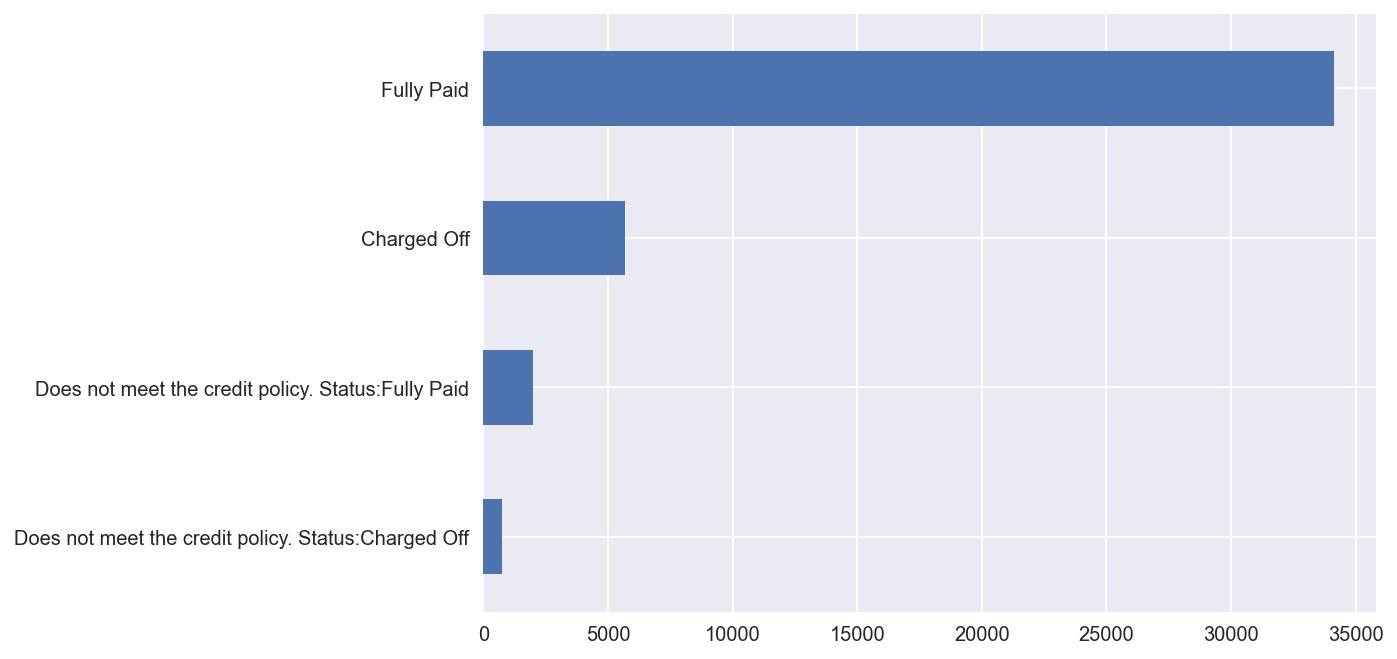

In [16]:
Loan["loan_status"].value_counts(ascending=True).plot(kind='barh')
Loan["loan_status"].value_counts()/Loan.shape[0]

There are four unique levels in the column we are interested to predict. As we are only interested in the fully paid and charged off levels, we will eliminate these to two levels later.

# ***II. Feature Engineering***


In [17]:
Loan.describe()

loan_amnt  funded_amnt  funded_amnt_inv  int_rate  installment  \
count  42535.000    42535.000        42535.000 42535.000    42535.000   
mean   11089.723    10821.586        10139.831     0.122      322.623   
std     7410.938     7146.915         7131.686     0.037      208.927   
min      500.000      500.000            0.000     0.054       15.670   
25%     5200.000     5000.000         4950.000     0.096      165.520   
50%     9700.000     9600.000         8500.000     0.120      277.690   
75%    15000.000    15000.000        14000.000     0.147      428.180   
max    35000.000    35000.000        35000.000     0.246     1305.190   

       annual_inc       dti  delinq_2yrs  inq_last_6mths  \
count   42531.000 42535.000    42506.000       42506.000   
mean    69136.556    13.373        0.152           1.081   
std     64096.350     6.726        0.512           1.527   
min      1896.000     0.000        0.000           0.000   
25%     40000.000     8.200        0.000           0.000   
50%     59000.000    13.470        0.000           1.000   
75%     82500.000    18.680        0.000           2.000   
max   6000000.000    29.990       13.000          33.000   

       mths_since_last_delinq  mths_since_last_record  open_acc   pub_rec  \
count               15609.000                3651.000 42506.000 42506.000   
mean                   35.018                  59.176     9.344     0.058   
std                    22.418                  47.145     4.496     0.246   
min                     0.000                   0.000     1.000     0.000   
25%                    17.000                   0.000     6.000     0.000   
50%                    33.000                  85.000     9.000     0.000   
75%                    51.000                 101.000    12.000     0.000   
max                   120.000                 129.000    47.000     5.000   

        revol_bal  total_acc  out_prncp  out_prncp_inv  total_pymnt  \
count   42535.000  42506.000  42535.000      42535.000    42535.000   
mean    14297.861     22.124      0.000          0.000    12019.008   
std     22018.441     11.593      0.000          0.000     9094.163   
min         0.000      1.000      0.000          0.000        0.000   
25%      3635.000     13.000      0.000          0.000     5464.404   
50%      8821.000     20.000      0.000          0.000     9682.252   
75%     17251.000     29.000      0.000          0.000    16425.370   
max   1207359.000     90.000      0.000          0.000    58886.473   

       total_pymnt_inv  total_rec_prncp  total_rec_int  total_rec_late_fee  \
count        42535.000        42535.000      42535.000           42535.000   
mean         11311.863         9675.676       2239.981               1.517   
std           9038.152         7105.750       2585.057               7.830   
min              0.000            0.000          0.000               0.000   
25%           4792.255         4400.000        657.100               0.000   
50%           8955.870         8000.000       1339.160               0.000   
75%          15538.820        13499.995       2803.090               0.000   
max          58563.680        35000.020      23886.470             209.000   

       recoveries  collection_recovery_fee  last_pymnt_amnt  \
count   42535.000                42535.000        42535.000   
mean      101.834                   14.176         2613.246   
std       729.079                  161.179         4385.067   
min         0.000                    0.000            0.000   
25%         0.000                    0.000          211.050   
50%         0.000                    0.000          528.360   
75%         0.000                    0.000         3170.220   
max     29623.350                 7002.190        36115.200   

       collections_12_mths_ex_med  policy_code  acc_now_delinq  \
count                   42390.000    42535.000       42506.000   
mean                        0.000        1.000           0.000   
std  

As we can see from the summary statistics, there are lots of missing values in the dataset that we need to deal with.

### ***Propressing***

Remove and impute missing values

In [18]:
def clean_data(df):
    '''
    INPUT
    df - pandas dataframe

    OUTPUT
    df - a cleaned version of the original dataframe

    This function cleans df using the following steps :
    1. Drop all the rows without the target loan status
    2. Drop columns with no intereting information
    3. Drop columns related to information leakage
    4. For each numerical variable, fill with the medium value of the column.
    5. For each categorical variable, fill with the mode value of the column.
    6. Convert 'emp_length', 'earliest_cr_line' and 'revol_util' to numerical
    variables.
    7. Oridinal encoding categorical variables.
    '''

    # Drop rows without target loan status
    mask1 = df['loan_status'] == 'Fully Paid'
    mask2 = df['loan_status'] == 'Charged Off'
    df = df.loc[mask1 | mask2]

    # Drop columns
    df = df.drop(columns=['desc', 'sub_grade', 'emp_title', 'zip_code',
                          'addr_state', 'issue_d', 'pymnt_plan',
                          'policy_code', 'next_pymnt_d', 'title',
                          'initial_list_status', 'last_pymnt_d',
                          'application_type', 'hardship_flag',
                          'tax_liens'], axis=1)

    # Drop columns including up-to-date information of the loan status
    df = df.drop(columns=['total_rec_prncp', 'recoveries', 'total_pymnt',
                          'total_pymnt_inv', 'chargeoff_within_12_mths',
                          'last_pymnt_amnt', 'mths_since_last_delinq',
                          'last_credit_pull_d', 'total_rec_late_fee',
                          'delinq_2yrs', 'mths_since_last_record',
                          'collection_recovery_fee', 'total_rec_int',
                          'collections_12_mths_ex_med', 'out_prncp',
                          'out_prncp_inv', 'acc_now_delinq',
                          'delinq_amnt'], axis=1)

    # Fill numerical columns with the medium
    # Neural Network won't work with NA's
    # Lots of information will lose if simply dropping NA's
    # Distributions of numerical variables aren't normal（right-skewed）
    # So median would be a good representative 
    num_vars = df.select_dtypes(include=['number']).columns
    for col in num_vars:
        df[col].fillna((df[col].median()), inplace=True)

    # Fill categorical columns with the mode
    cat_vars = df.select_dtypes(include=['object']).columns
    for col in cat_vars:
        df[col].fillna((df[col].mode()[0]), inplace=True)

    # Convert to numerical variables.
    import re
    df['emp_length'] = df['emp_length'].apply(
        lambda x: re.findall(r'\d+', x)[0])
    df['emp_length'] = df['emp_length'].astype(int)
    df['earliest_cr_line'] = df['earliest_cr_line'].apply(
        lambda x: (2020-float(re.findall(r'\d+', x)[0])))
    df['revol_util'] = df['revol_util'].str.rstrip('%').astype('float') / 100.0

    # Ordinal encoding
    cat_vars = list(df.select_dtypes(include=['object']).columns)
    cat_vars.remove('loan_status')
    for var in cat_vars:
        class_mapping = {label:idx for idx, label in enumerate(np.unique(df[var]))}
        print(class_mapping)
        df[var]=df[var].map(class_mapping)
    return df

In [19]:
cleaned_loan = clean_data(Loan)

{' 36 months': 0, ' 60 months': 1}
{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6}
{'MORTGAGE': 0, 'NONE': 1, 'OTHER': 2, 'OWN': 3, 'RENT': 4}
{'Not Verified': 0, 'Source Verified': 1, 'Verified': 2}
{'car': 0, 'credit_card': 1, 'debt_consolidation': 2, 'educational': 3, 'home_improvement': 4, 'house': 5, 'major_purchase': 6, 'medical': 7, 'moving': 8, 'other': 9, 'renewable_energy': 10, 'small_business': 11, 'vacation': 12, 'wedding': 13}


In [20]:
check_missing_value(cleaned_loan)

The number of columns with missing values: 0


In [21]:
cleaned_loan.head()

loan_amnt  funded_amnt  funded_amnt_inv  term  int_rate  installment  \
0   5000.000     5000.000         4975.000     0     0.106      162.870   
1   2500.000     2500.000         2500.000     1     0.153       59.830   
2   2400.000     2400.000         2400.000     0     0.160       84.330   
3  10000.000    10000.000        10000.000     0     0.135      339.310   
4   3000.000     3000.000         3000.000     1     0.127       67.790   

   grade  emp_length  home_ownership  annual_inc  verification_status  \
0      1          10               4   24000.000                    2   
1      2           1               4   30000.000                    1   
2      2          10               4   12252.000                    0   
3      2          10               4   49200.000                    1   
4      1           1               4   80000.000                    1   

   loan_status  purpose    dti  earliest_cr_line  inq_last_6mths  open_acc  \
0   Fully Paid        1 27.650            35.000           1.000     3.000   
1  Charged Off        0  1.000            21.000           5.000     3.000   
2   Fully Paid       11  8.720            19.000           2.000     2.000   
3   Fully Paid        9 20.000            24.000           1.000    10.000   
4   Fully Paid        9 17.940            24.000           0.000    15.000   

   pub_rec  revol_bal  revol_util  total_acc  pub_rec_bankruptcies  
0    0.000  13648.000       0.837      9.000                 0.000  
1    0.000   1687.000       0.094      4.000                 0.000  
2    0.000   2956.000       0.985     10.000                 0.000  
3    0.000   5598.000       0.210     37.000                 0.000  
4    0.000  27783.000       0.539     38.000                 0.000

In [22]:
# One hot encoding for Y
class_mapping = {"Fully Paid":0, "Charged Off":1}
cleaned_loan['loan_status']=cleaned_loan['loan_status'].map(class_mapping)

In [23]:
cleaned_loan.head()

loan_amnt  funded_amnt  funded_amnt_inv  term  int_rate  installment  \
0   5000.000     5000.000         4975.000     0     0.106      162.870   
1   2500.000     2500.000         2500.000     1     0.153       59.830   
2   2400.000     2400.000         2400.000     0     0.160       84.330   
3  10000.000    10000.000        10000.000     0     0.135      339.310   
4   3000.000     3000.000         3000.000     1     0.127       67.790   

   grade  emp_length  home_ownership  annual_inc  verification_status  \
0      1          10               4   24000.000                    2   
1      2           1               4   30000.000                    1   
2      2          10               4   12252.000                    0   
3      2          10               4   49200.000                    1   
4      1           1               4   80000.000                    1   

   loan_status  purpose    dti  earliest_cr_line  inq_last_6mths  open_acc  \
0            0        1 27.650            35.000           1.000     3.000   
1            1        0  1.000            21.000           5.000     3.000   
2            0       11  8.720            19.000           2.000     2.000   
3            0        9 20.000            24.000           1.000    10.000   
4            0        9 17.940            24.000           0.000    15.000   

   pub_rec  revol_bal  revol_util  total_acc  pub_rec_bankruptcies  
0    0.000  13648.000       0.837      9.000                 0.000  
1    0.000   1687.000       0.094      4.000                 0.000  
2    0.000   2956.000       0.985     10.000                 0.000  
3    0.000   5598.000       0.210     37.000                 0.000  
4    0.000  27783.000       0.539     38.000                 0.000

## ***Train-test Split***

In [24]:
from sklearn.model_selection import train_test_split

Y = cleaned_loan["loan_status"]
X = cleaned_loan.drop(["loan_status"], axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, random_state=2020, test_size=.30, stratify=Y
)

## ***Transformation***

In [25]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# ***III. Model Fitting***

In [45]:
from sklearn import metrics
from sklearn.metrics import roc_curve


def plot_ROC(model, labels):
    '''Plot ROC and save the pic'''
    Y_test_pred = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(Y_test, Y_test_pred)
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label=labels)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve - {} model'.format(labels))
    plt.legend(loc='best')
    plt.savefig(labels+'_ROC.png', dpi=150)
    plt.show()
    print("AUC score is", metrics.auc(fpr, tpr))
    return

In [46]:
def plot_feature_importance(model, labels):
    '''Plot the feature importance plot and save the file'''
    # feature importance
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    # Print the feature ranking
    temp = pd.DataFrame(importances[indices], X.columns[indices])
    temp.columns = ["Feature importance"]
    temp["Feature name"] = temp.index
    plt.subplots(figsize=(10, 8))
    ax = sns.barplot(
        y="Feature name",
        x="Feature importance",
        data=temp.iloc[:20, ]
    )
    plt.title("Feature Importance_"+labels)
    plt.savefig(labels+'_FI.png', dpi=150)
    return

In [93]:
def training_score(model):
    print("Training accuracy is {:.4f}".format(model.score(X_train, Y_train)))


def testing_score(model):
    print("Testing accuracy is {:.4f}".format(model.score(X_test, Y_test)))

## ***Random Forrest***

In [86]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Random Forest
classifier_RF = RandomForestClassifier()

# Possible hyperparamter options for Random Forest
# Choose the number of trees
parameters = {
    'n_estimators' : [100,500,1000]
}
Grid_RF = GridSearchCV(RandomForestClassifier(),parameters, cv=5)
Grid_RF.fit(X_train, Y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [94]:
testing_score(best_RF_model)

Testing accuracy is 0.8572


In [88]:
# best random forest
best_RF_model = Grid_RF.best_estimator_

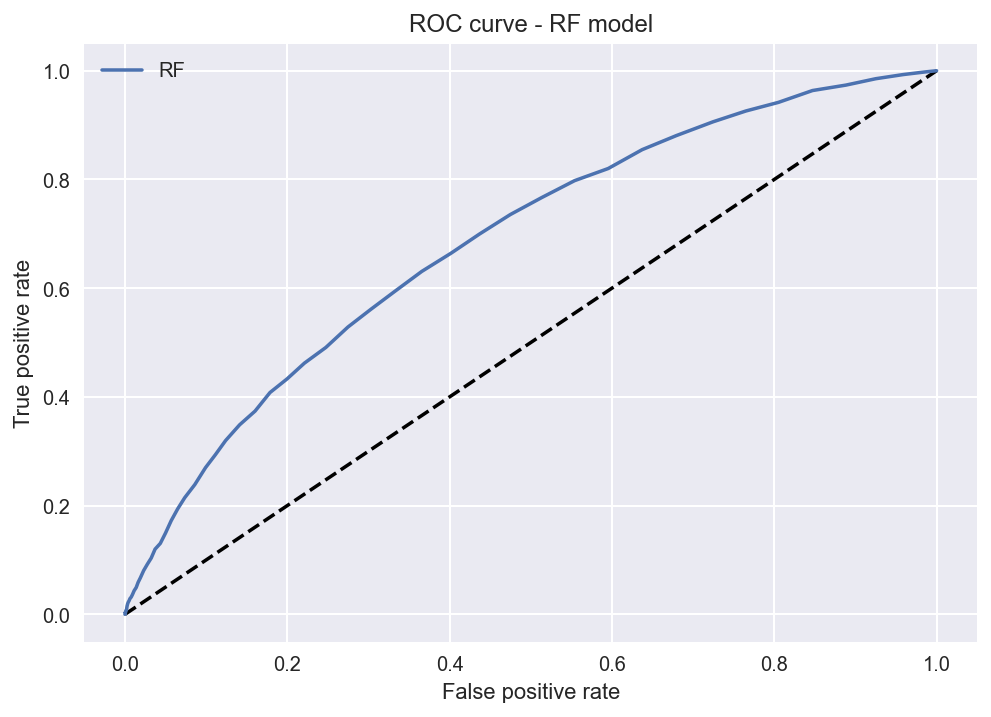

AUC score is 0.6849437685295038


In [89]:
plot_ROC(best_RF_model, "RF")

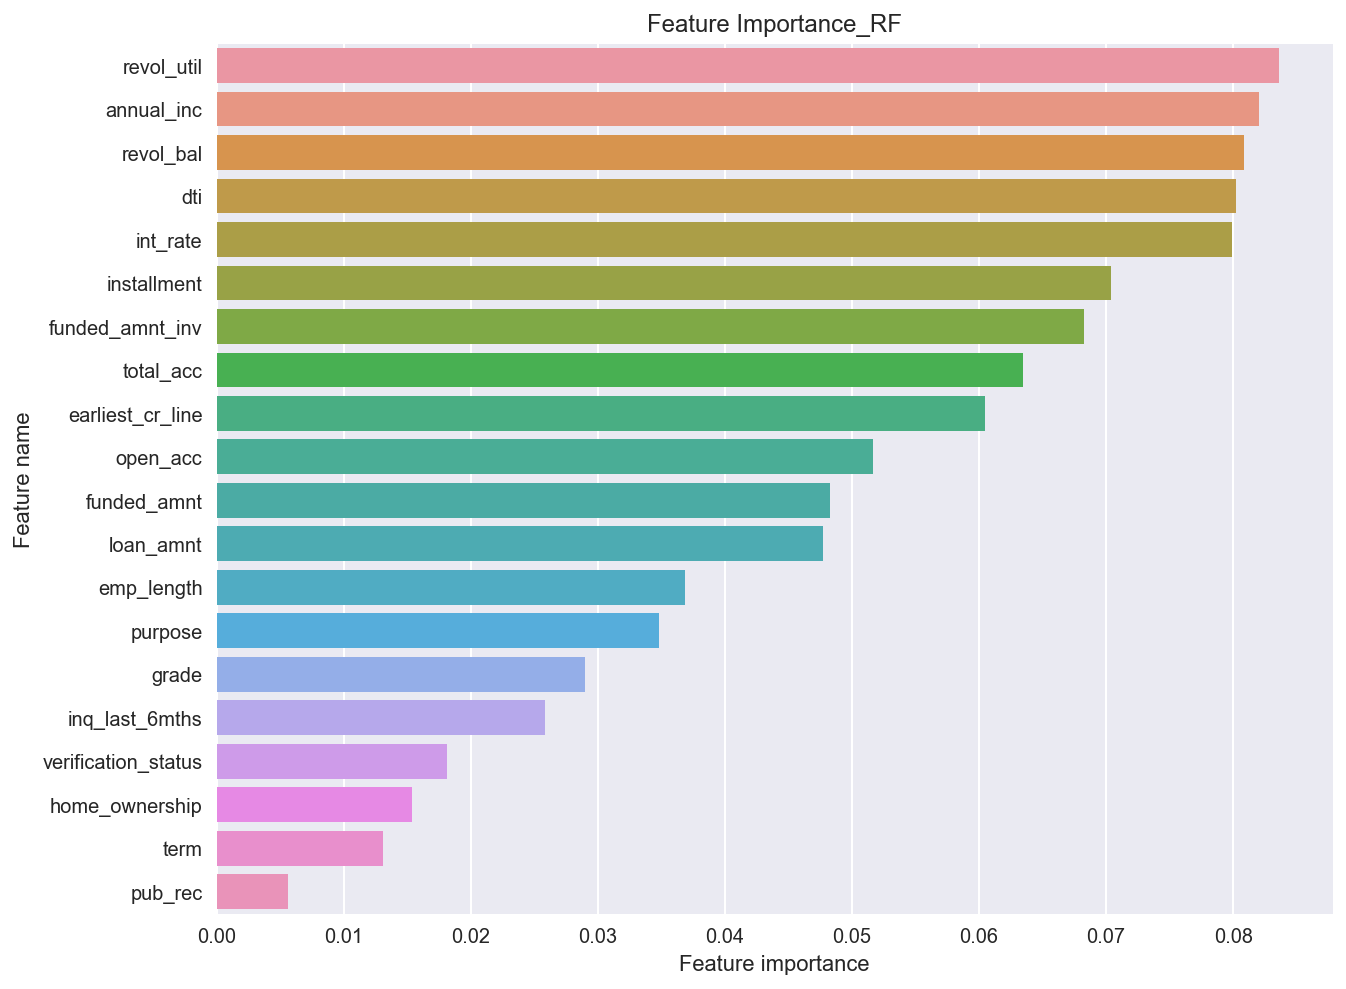

In [90]:
plot_feature_importance(best_RF_model, "RF")

In [91]:
training_score(best_RF_model)

Training accuracy is 1.000


## ***Support Vector Machine***

In [52]:
from sklearn.svm import SVC 

classifier_SVC = SVC(probability=True)
classifier_SVC.fit(X_train, Y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

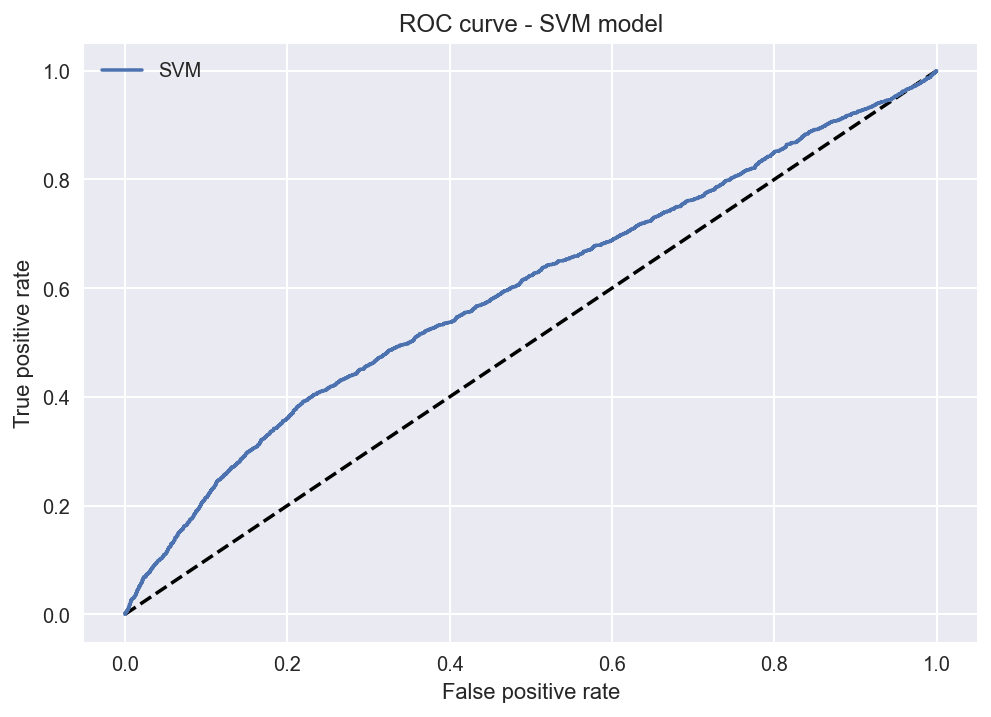

AUC score is 0.5935360302727182


In [53]:
plot_ROC(classifier_SVC, "SVM")

In [95]:
testing_score(classifier_SVC)

Testing accuracy is 0.8575


## ***Light GBM***

In [34]:
import lightgbm as lgb
import random

from sklearn.metrics import confusion_matrix
random.seed(2020)

In [35]:
# Use grid search and 5 fold cross validation to find the best model
parameters = {
    "n_estimators": (50, 100, 200),
    "max_depth" : (5,),
    "reg_lambda" : (0.1,0.01)
}
model_lgb =lgb.LGBMClassifier(eval_metric = "auc")
Grid_lgbm = GridSearchCV(model_lgb,parameters, cv=5,  scoring = "roc_auc")

In [36]:
Grid_lgbm.fit(X_train, Y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0, eval_metric='auc',
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': (5,), 'n_estimators': (50, 100, 200),

In [37]:
best_lgbm = Grid_lgbm.best_estimator_
best_lgbm

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               eval_metric='auc', importance_type='split', learning_rate=0.1,
               max_depth=5, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=50, n_jobs=-1, num_leaves=31,
               objective=None, random_state=None, reg_alpha=0.0,
               reg_lambda=0.01, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

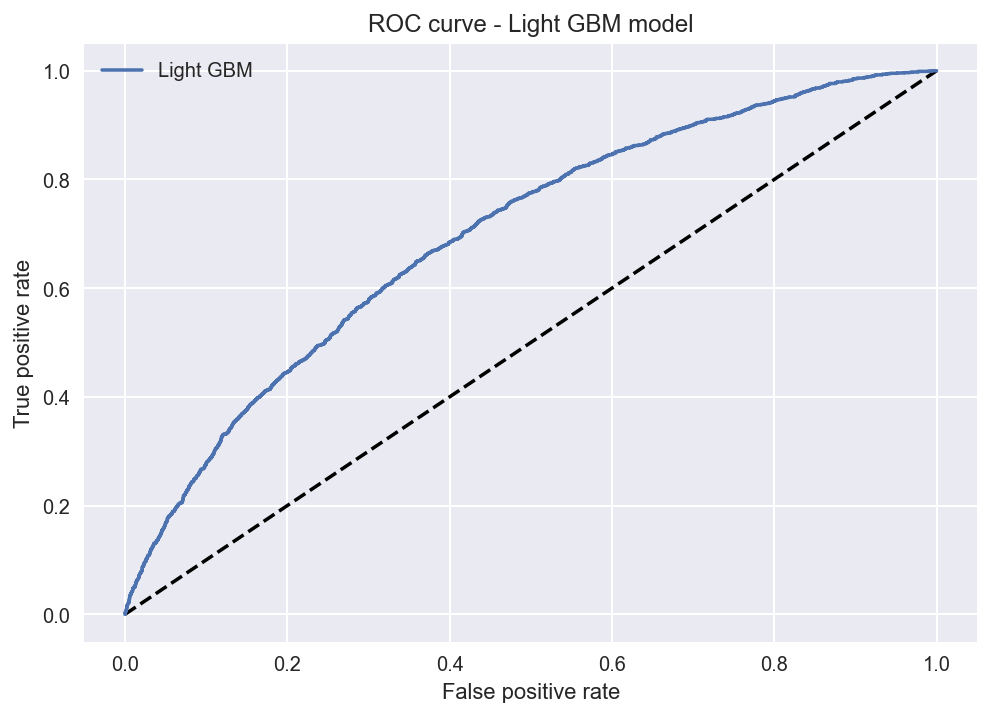

AUC score is 0.6973941303529319


In [96]:
plot_ROC(best_lgbm, "Light GBM")

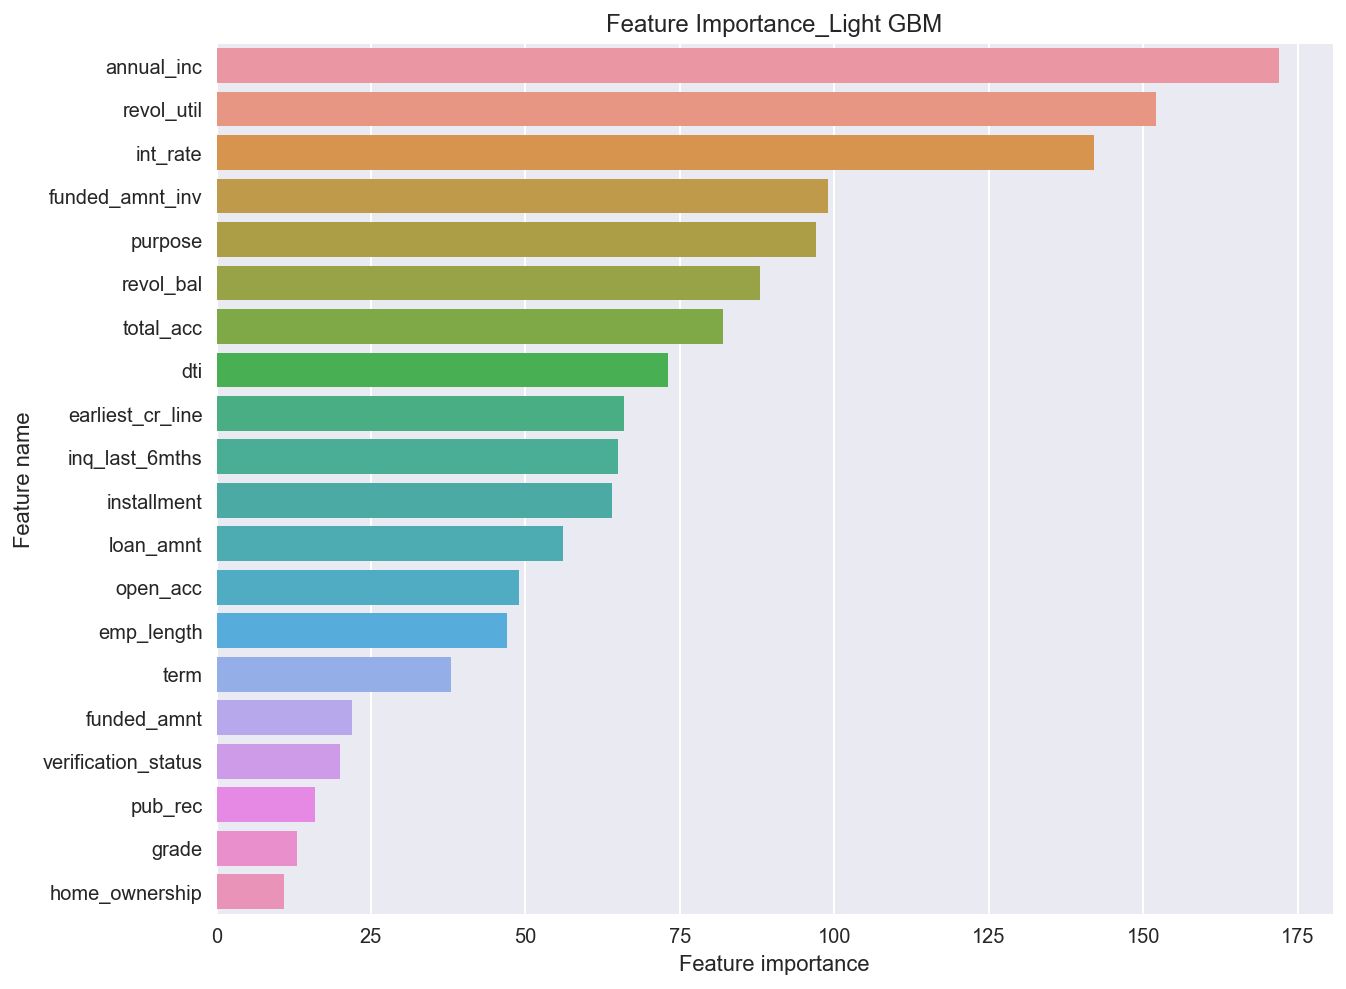

In [97]:
plot_feature_importance(best_lgbm, "Light GBM")

In [98]:
training_score(best_lgbm)

Training accuracy is 0.8594


In [103]:
testing_score(best_lgbm)

Testing accuracy is 0.8570


## ***Neural Network***

In [100]:
from sklearn.neural_network import MLPClassifier

# build a multilayer perceptron classifier with 3 hidden layers
mlp = MLPClassifier(hidden_layer_sizes=(20, 30, 20))
mlp.fit(X_train, Y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(20, 30, 20), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

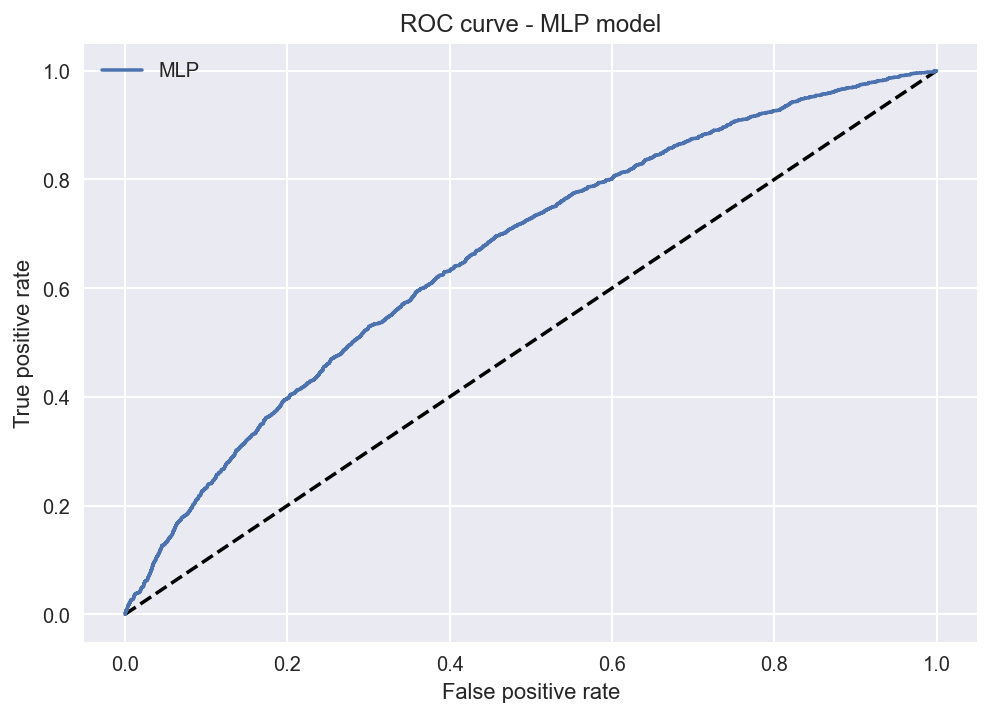

AUC score is 0.6613510774288064


In [101]:
plot_ROC(mlp, "MLP")

In [102]:
training_score(mlp)

Training accuracy is 0.8675


In [104]:
testing_score(mlp)

Testing accuracy is 0.8451


# ***IV. Model Evaluation***

In [107]:
import itertools
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report


def confusion_plot(model, labels):
    """Plot the confusion plot of the test set"""
    Y_test_pred = model.predict(X_test)
    cm = confusion_matrix(Y_test, Y_test_pred)
    model_eval = precision_recall_fscore_support(Y_test, Y_test_pred)
    print("The precision is", model_eval[0])
    print("The recall is", model_eval[1])
    print("The F1 score is", model_eval[2])
    cmap = plt.cm.Reds

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(['No', 'Yes']))
    plt.xticks(tick_marks, ['No', 'Yes'], rotation=45)
    plt.yticks(tick_marks, ['No', 'Yes'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j, i, format(cm[i, j], 'd'),
            horizontalalignment="center",
            color="white" if cm[i, j] > cm.max() / 2 else "black"
        )
    ax = plt.axes()
    t = 'Confusion Matrix:'
    ax.set_title(t, fontweight="bold", size=10)
    plt.savefig(labels+'_cm.png', dpi=150)
    plt.show()

## ***Random Forrest***

In [108]:
# Make predictions on the testing set
Y_pred_rf = best_RF_model.predict(X_test)
testing_score(best_RF_model)

Testing accuracy is 0.8572


In [109]:
print(classification_report(Y_test, Y_pred_rf))

              precision    recall  f1-score   support

           0       0.86      1.00      0.92     10235
           1       0.47      0.01      0.02      1701

    accuracy                           0.86     11936
   macro avg       0.66      0.50      0.47     11936
weighted avg       0.80      0.86      0.79     11936



The precision is [0.85865635 0.46511628]
The recall is [0.99775281 0.01175779]
The F1 score is [0.92299349 0.02293578]


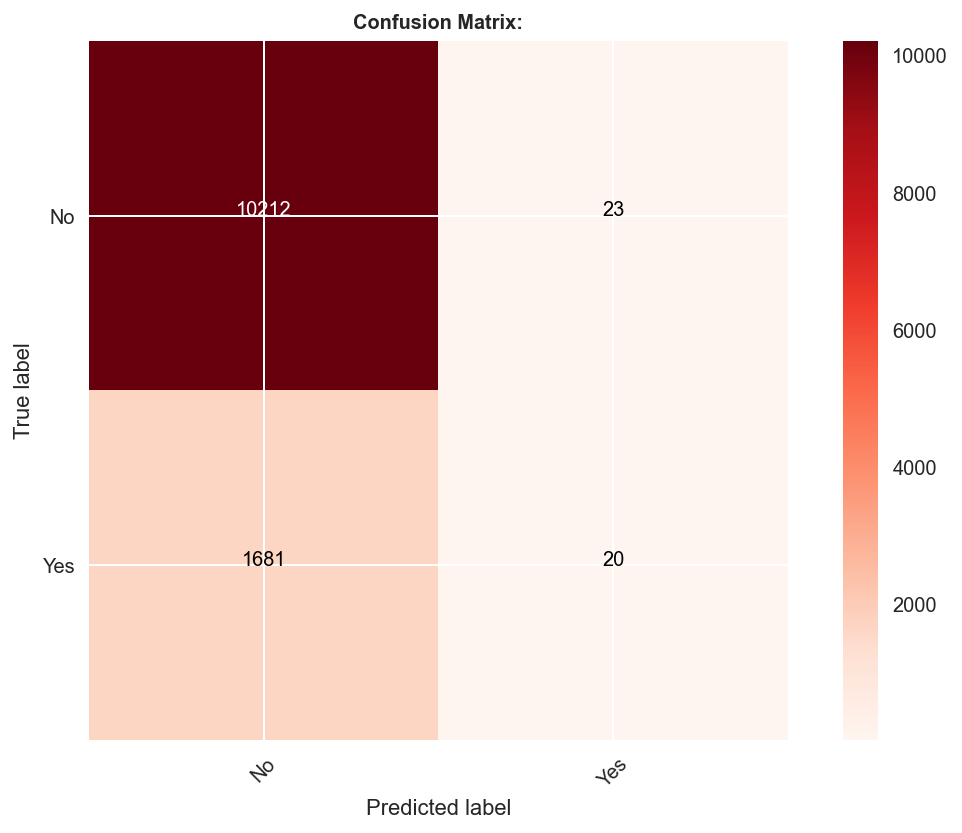

In [110]:
confusion_plot(best_RF_model,"cm_RF")

## ***Support Vector Machine***

In [111]:
# Make predictions on the testing set
Y_pred_svm = classifier_SVC.predict(X_test)
testing_score(classifier_SVC)

Testing accuracy is 0.8575


In [112]:
print(classification_report(Y_test, Y_pred_svm))

              precision    recall  f1-score   support

           0       0.86      1.00      0.92     10235
           1       0.00      0.00      0.00      1701

    accuracy                           0.86     11936
   macro avg       0.43      0.50      0.46     11936
weighted avg       0.74      0.86      0.79     11936



The precision is [0.85748995 0.        ]
The recall is [1. 0.]
The F1 score is [0.92327816 0.        ]


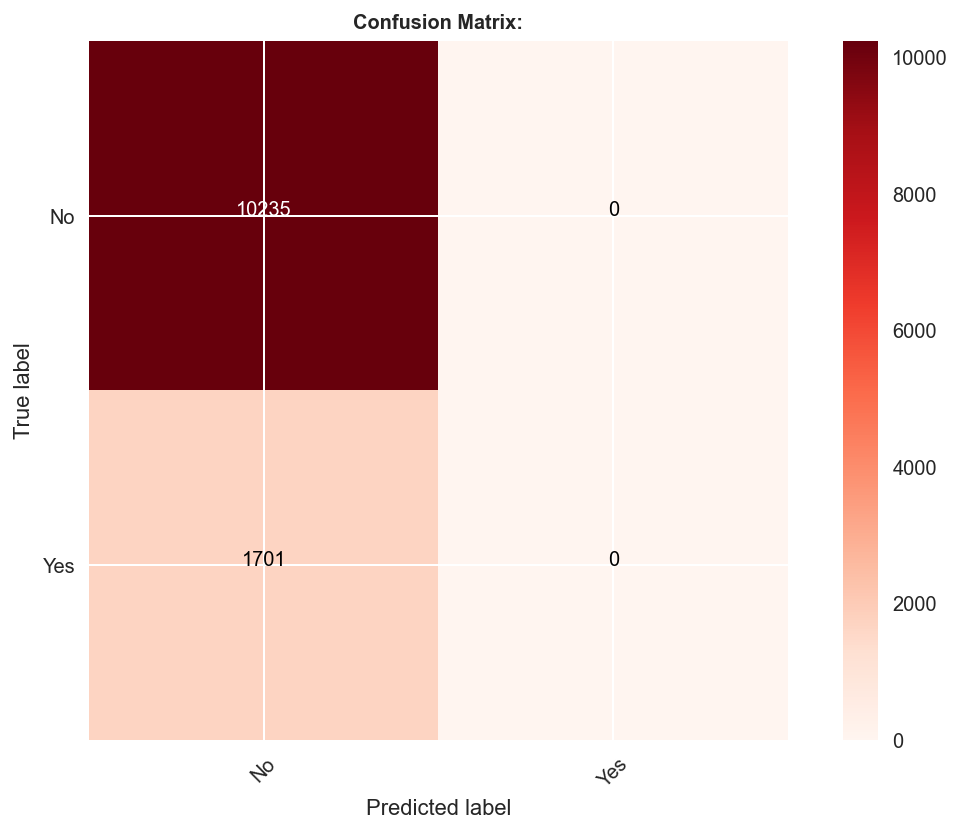

In [113]:
confusion_plot(classifier_SVC,"cm_svm")

From this confusion matrix, we can see that this classifer performed really bad on this testing dataset. It simply predicts all the observations as no's.

## ***Light GBM***

In [40]:
# Make predictions on the testing set
Y_pred_lightgbm = best_lgbm.predict(X_test)
testing_score(best_lgbm)

Testing accuracy is 0.857


In [41]:
print(classification_report(Y_test, Y_pred_lightgbm))

              precision    recall  f1-score   support

           0       0.86      1.00      0.92     10235
           1       0.41      0.01      0.02      1701

    accuracy                           0.86     11936
   macro avg       0.63      0.50      0.47     11936
weighted avg       0.79      0.86      0.79     11936



The precision is [0.85819892 0.40625   ]
The recall is [0.99814362 0.00764256]
The F1 score is [0.92289625 0.01500289]


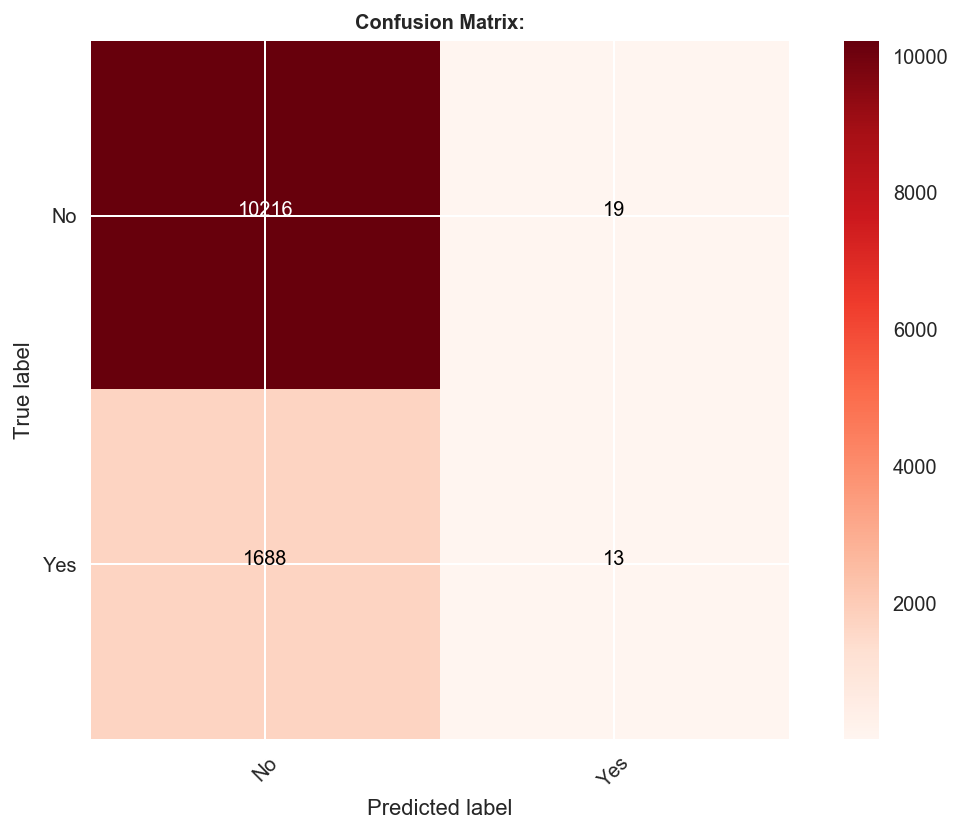

In [42]:
confusion_plot(best_lgbm,"lgbm")

## ***Nerual Network***

In [43]:
# Make predictions on the testing set
Y_pred_nn = mlp.predict(X_test)
testing_score(mlp)

Testing accuracy is 0.846


In [44]:
print(classification_report(Y_test, Y_pred_nn))

              precision    recall  f1-score   support

           0       0.86      0.97      0.92     10235
           1       0.31      0.07      0.11      1701

    accuracy                           0.85     11936
   macro avg       0.59      0.52      0.51     11936
weighted avg       0.78      0.85      0.80     11936



The precision is [0.86301133 0.31367292]
The recall is [0.97498779 0.06878307]
The F1 score is [0.91558859 0.11282546]


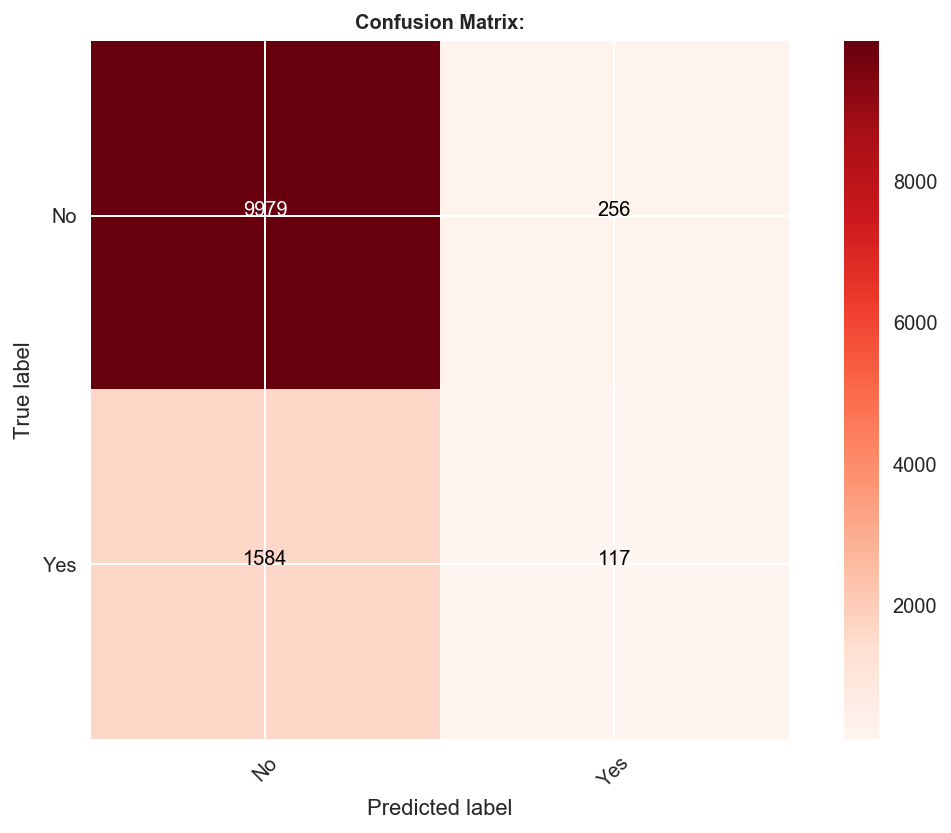

In [45]:
confusion_plot(mlp,"mlp")

# ***V. Conclusion***

When comparing the results from Light GBM with these from MLP, we can see that MLP did a better job on the training set with an 87 % training accuracy but the accuracy dropped by about 2 % on the testing set.

From the confusion matrix, we can see our classifier has high precision but low recall. This means the proportion of borrowers predicted to have good loan behaviors are indeed those who would fully pay the loan is high. But when the true label is charge-off, our classifier is not sensitive enough to notice that. This might be caused by the imbalanced class in the dataset. Actually, in this case, we do care more about precision as investors want to invest in those who are less likely to default.

During the prepossessing, one important thing to notice is information leakage. As our dataset contains much up-to-date information related to the number of delinquency month and charge off collection fee etc, these features suggest a charge-off the loan. But at the time we decide to invest, we don't have this information. So it is better to remove these columns when building the model.

To summarize, in this project we found the interest rate had a strong connection with the applicant's credit grade. A 60-month term loan has about a 3 % higher interest rate than a 48-month term loan. Most borrowers apply for a loan to pay other sources of debt. The geographical distribution of lenders is almost consistent with America's demographic profile.

If you are interested in this topic, you can find a larger dataset through this link with 2260668 rows. Here I am only using a subset for computational efficiency.

https://www.kaggle.com/wendykan/lending-club-loan-data?